In [1]:
import sys
sys.path.append('/opt/ros/melodic/lib/python2.7/dist-packages')
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import rosbag
import rospy
from os import listdir
from os.path import isfile, join

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [31]:
bag_dir = '/home/tim/BT_Tests/pose_estimation'

bag_names = [f for f in listdir(bag_dir) if isfile(join(bag_dir, f))]

bags = []
bag_times = []

for bag_name in bag_names:
    bag = rosbag.Bag(join(bag_dir, bag_name))
    bags.append(bag)
    date_time = bag_name.split(sep='.')[0]
    bag_times.append(date_time)

print(bags)
print(bag_times)

[<rosbag.bag.Bag object at 0x7f86747b3fd0>, <rosbag.bag.Bag object at 0x7f866c63d910>, <rosbag.bag.Bag object at 0x7f866c5b97d0>, <rosbag.bag.Bag object at 0x7f866bf24c90>, <rosbag.bag.Bag object at 0x7f867005c210>, <rosbag.bag.Bag object at 0x7f866c5b0490>]
['2022-07-20-12-10-14', '2022-07-20-12-16-36', '2022-07-20-12-08-01', '2022-07-20-12-14-24', '2022-07-20-12-15-58', '2022-07-20-12-09-05']


In [32]:
palette = sns.color_palette('pastel')
sns.set_style('whitegrid') # darkgrid, whitegrid, dark, white and
plt.rc('lines', linewidth=3)     # linewidth
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('font', size=18)          # controls default text sizes

In [33]:
def cut_list(list, time):
    retList = []
    for i, t in enumerate(time):
        if t < 40.0:
            retList.append(list[i])
        else:
            break
    return retList

# Plot Pose Estimation Results

In [34]:
size = len(bags)
all_position_gt = []
all_time_gt = []
all_position_est = []
all_time_est = []
all_errors = []
all_time_errors = []

for i, bag in enumerate(bags):
    stamp_estimate = []
    stamp_gt = []
    stamp_error = []
    position_estimate = []
    position_gt = []
    error = []

    for topic, msg, t in bag.read_messages('/geranos/visual_servoing/estimated_pole_position'):
        stamp_estimate.append(msg.header.stamp.secs + msg.header.stamp.nsecs * 10**(-9))
        position_estimate.append([msg.point.x , msg.point.y, msg.point.z])

    time_estimate = [s-stamp_estimate[0] for s in stamp_estimate]
    position_estimate = cut_list(position_estimate, time_estimate)
    time_estimate = cut_list(time_estimate, time_estimate)

    position_estimate = np.array(position_estimate)

    for topic, msg, t in bag.read_messages('/geranos/geranos_pole_white/vrpn_client/estimated_transform'):
        stamp_gt.append(msg.header.stamp.secs + msg.header.stamp.nsecs * 10**(-9))
        position_gt.append([msg.transform.translation.x , msg.transform.translation.y, msg.transform.translation.z])

    time_gt = [s-stamp_gt[0] for s in stamp_gt]
    position_gt = cut_list(position_gt, time_gt)
    time_gt = cut_list(time_gt, time_gt)

    position_gt = np.array(position_gt)

    for topic, msg, t in bag.read_messages('/geranos/visual_servoing/error_vector'):
        stamp_error.append(msg.header.stamp.secs + msg.header.stamp.nsecs * 10**(-9))
        error.append([msg.point.x , msg.point.y])

    time_error = [s-stamp_error[0] for s in stamp_error]
    error = cut_list(error, time_error)
    time_error = cut_list(time_error, time_error)

    error = np.array(error)

    all_position_gt.append(position_gt)
    all_position_est.append(position_estimate)
    all_time_gt.append(time_gt)
    all_time_est.append(time_estimate)
    all_errors.append(error)
    all_time_errors.append(time_error)

# Distances

In [35]:
distances = []
for i,bag in enumerate(bags):
    position_uav = []
    for topic, msg, t in bag.read_messages('/geranos/visual_servoing/transformed_odometry'):
        position_uav.append(msg.pose.pose.position.x)
        position_uav.append(msg.pose.pose.position.y)
        break
    position_pole = [all_position_gt[i][0][0], all_position_gt[i][0][1]]
    distance_vec = [position_uav[0] - position_pole[0], position_uav[1] - position_pole[1]]
    distance_vec = np.array(distance_vec)
    distance = np.linalg.norm(distance_vec)
    distances.append(distance)

# Plot Estimation Results

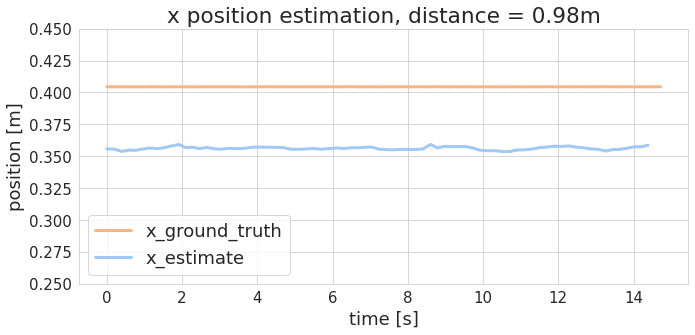

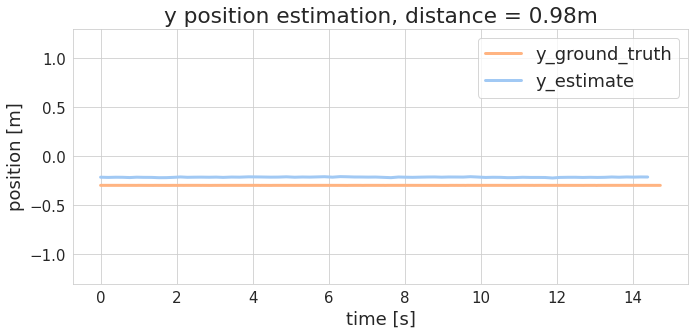

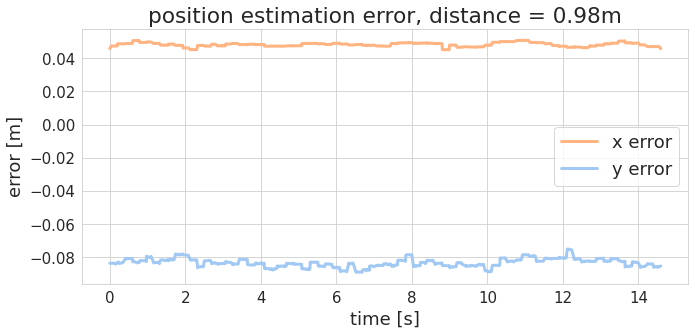

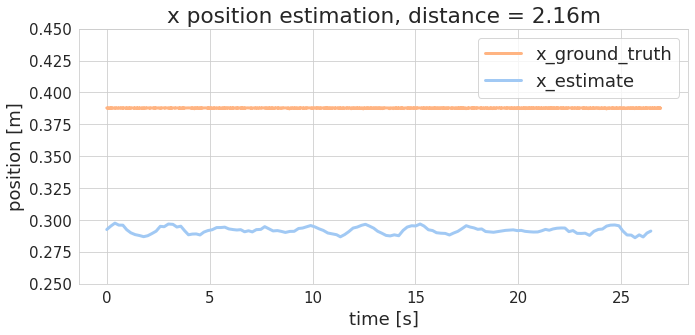

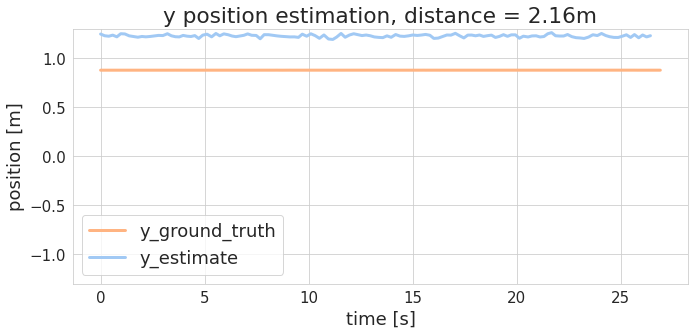

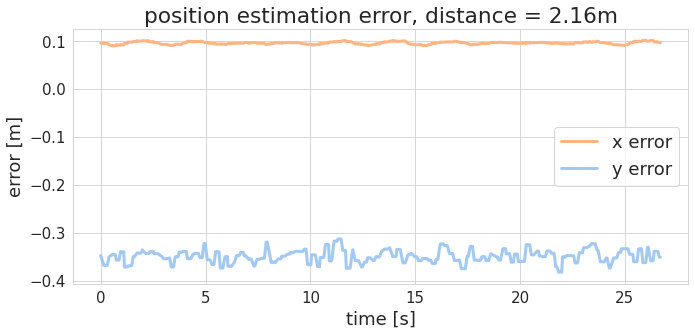

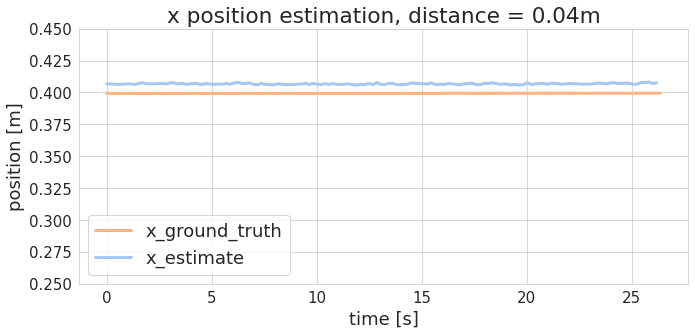

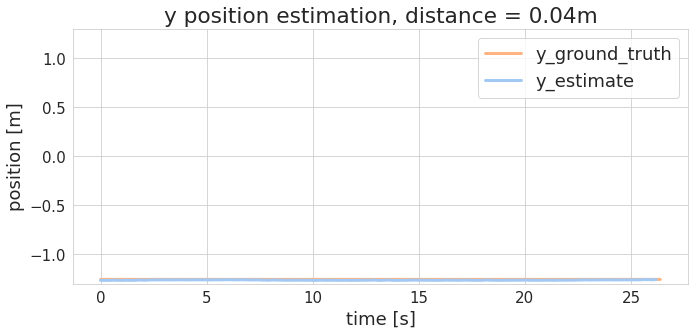

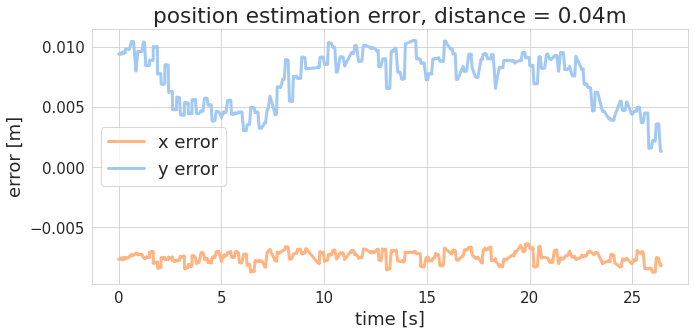

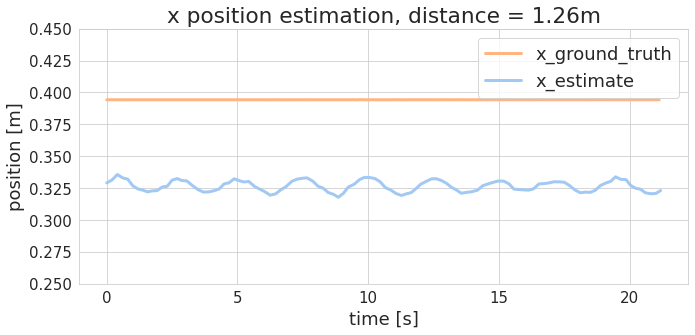

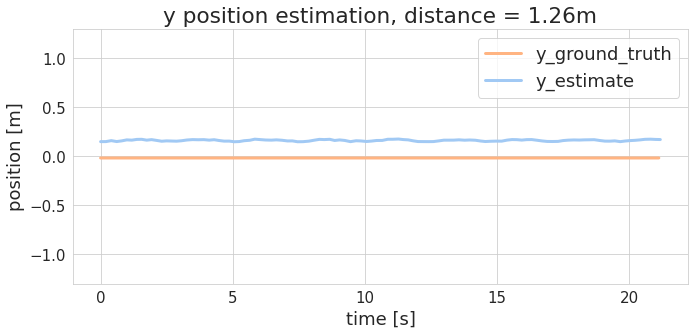

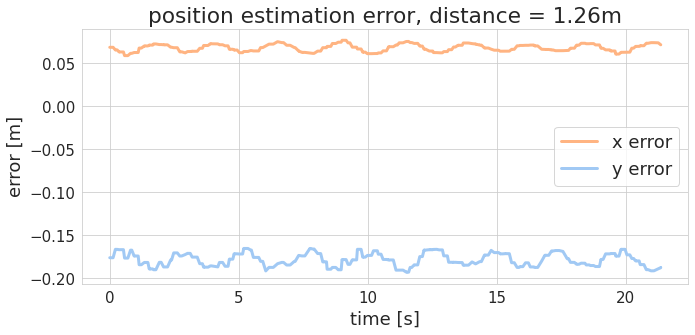

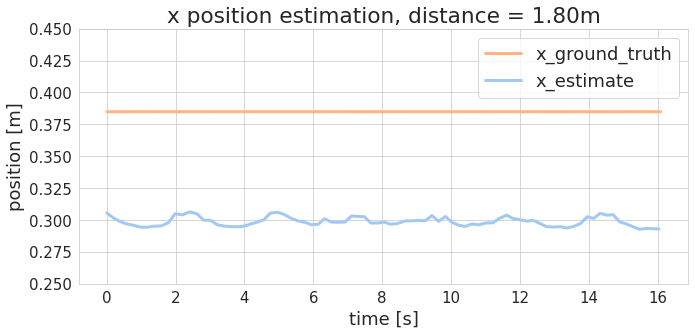

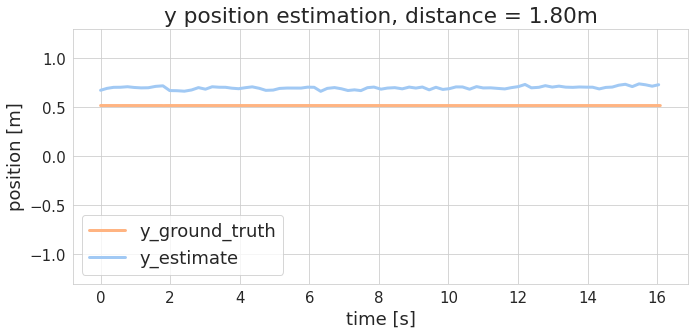

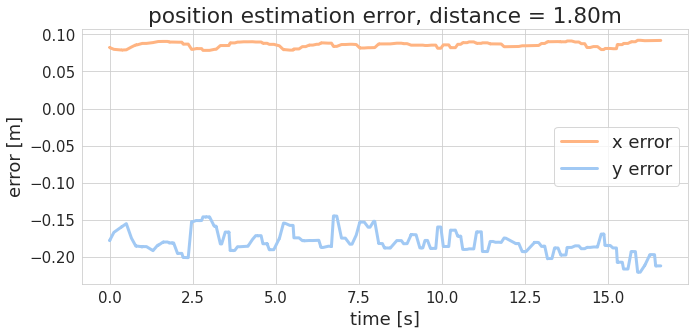

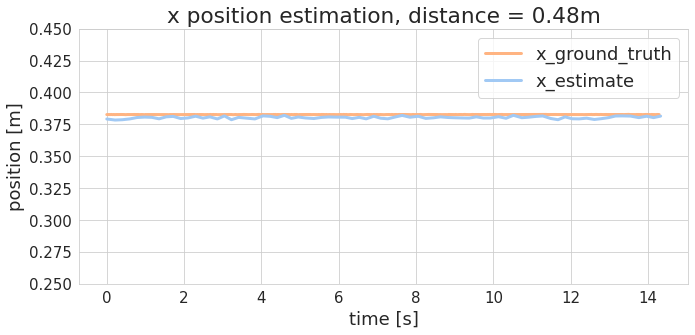

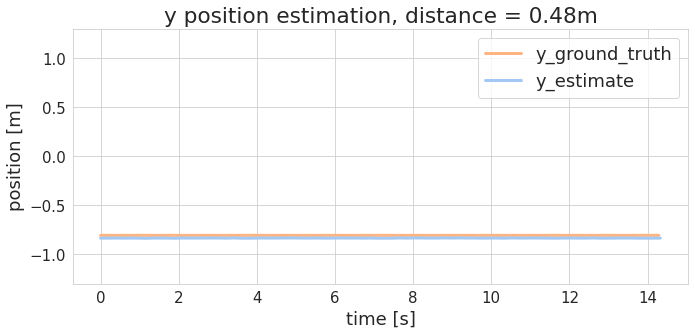

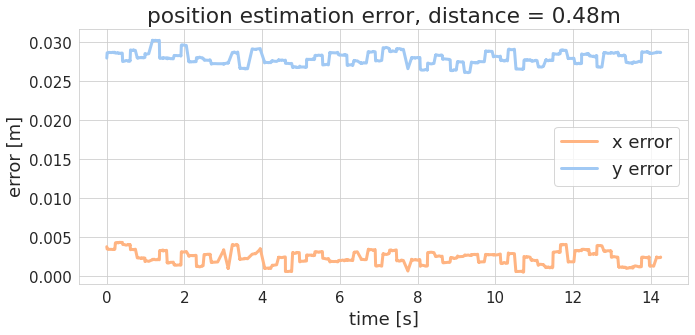

In [36]:
#Visualization
for i in range(len(bags)):
    position_gt = all_position_gt[i]
    position_estimate = all_position_est[i]
    errors = all_errors[i]
    time_gt = all_time_gt[i]
    time_estimate = all_time_est[i]
    time_error = all_time_errors[i]
    date_time = bag_times[i]

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 5), tight_layout=True)

    ax.set(title='x position estimation, distance = ' + "%.2f" % distances[i] + "m", xlabel='time [s]', ylabel='position [m]')
    ax.plot(time_gt,position_gt[:,0],color = palette[1],label = 'x_ground_truth')
    ax.plot(time_estimate,position_estimate[:,0],color = palette[0],label = 'x_estimate')
    ax.set_ylim(0.25,0.45)
    ax.legend()

    plt.savefig('/home/tim/Pictures/distance_plots/pose_est_x_dist_'+"%.2f" % distances[i]+'.pdf')

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 5), tight_layout=True)

    ax.set(title='y position estimation, distance = ' + "%.2f" % distances[i] + "m", xlabel='time [s]', ylabel='position [m]')
    ax.plot(time_gt,position_gt[:,1],color = palette[1],label = 'y_ground_truth')
    ax.plot(time_estimate,position_estimate[:,1],color = palette[0],label = 'y_estimate')
    ax.set_ylim(-1.30,1.30)
    ax.legend()

    plt.savefig('/home/tim/Pictures/distance_plots/pose_est_y_dist_'+"%.2f" % distances[i]+'.pdf')

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 5), tight_layout=True)

    ax.set(title='position estimation error, distance = ' + "%.2f" % distances[i] + "m", xlabel='time [s]', ylabel='error [m]')
    ax.plot(time_error,errors[:,0],color = palette[1],label = 'x error')
    ax.plot(time_error,errors[:,1],color = palette[0],label = 'y error')
    ax.legend()

    plt.savefig('/home/tim/Pictures/distance_plots/pose_est_error_'+"%.2f" % distances[i]+'.pdf')

# Mean and Std Dev of errors

In [37]:
means_x = []
means_y = []
std_devs_x = []
std_devs_y = []
for i in range(len(bags)):
    errors = all_errors[i]
    time_error = all_time_errors[i]
    means_x.append(errors[:,0].mean())
    std_devs_x.append(errors[:,0].std())
    means_y.append(errors[:,1].mean())
    std_devs_y.append(errors[:,1].std())
    print(std_devs_x)

[0.0011515966385600316]
[0.0011515966385600316, 0.0026499505706648854]
[0.0011515966385600316, 0.0026499505706648854, 0.00048485337072724224]
[0.0011515966385600316, 0.0026499505706648854, 0.00048485337072724224, 0.0040722877114367445]
[0.0011515966385600316, 0.0026499505706648854, 0.00048485337072724224, 0.0040722877114367445, 0.0037678101742935114]
[0.0011515966385600316, 0.0026499505706648854, 0.00048485337072724224, 0.0040722877114367445, 0.0037678101742935114, 0.0008531170728109083]


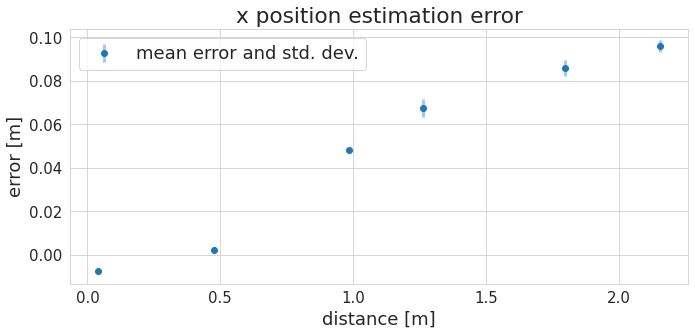

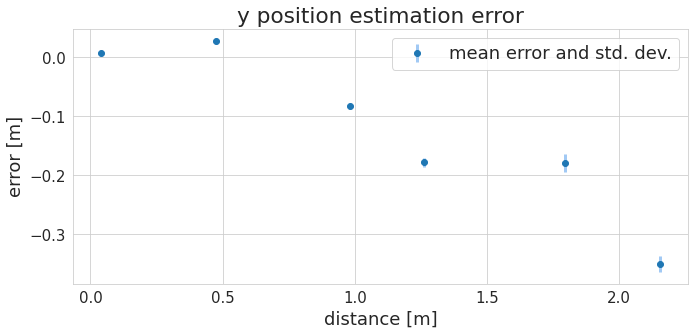

In [38]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 5), tight_layout=True)

ax.set(title='x position estimation error', xlabel='distance [m]', ylabel='error [m]')
ax.errorbar(distances,means_x,yerr=std_devs_x, fmt='o', ecolor=palette[0], label='mean error and std. dev.')
ax.legend()

plt.savefig('/home/tim/Pictures/distance_plots/pose_est_x_mean_stddev.pdf')

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10, 5), tight_layout=True)

ax.set(title='y position estimation error', xlabel='distance [m]', ylabel='error [m]')
ax.errorbar(distances,means_y,yerr=std_devs_y, fmt='o', ecolor=palette[0], label='mean error and std. dev.')
ax.legend()

plt.savefig('/home/tim/Pictures/distance_plots/pose_est_y_mean_stddev.pdf')